# Simulation of The Queue Reactive Model
## Based on the paper : 
### Simulating and Analyzing Order Book Data: The Queue-Reactive Model
### Article in Journal of the American Statistical Association · December 2013
### Weibing Huang, Charles-Albert Lehalle, and Mathieu Rosenbaum

# Imports

In [1]:
# Imports
from IPython.display import display, HTML
import os
import pandas as pd, datetime as dt, numpy as np, matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import sys
import datetime as dt
from apscheduler.schedulers.background import BackgroundScheduler

# limit logging of scheduler
import logging
logging.basicConfig()
logging.getLogger('apscheduler').setLevel(logging.CRITICAL)

# Display options
thisnotebooksys = sys.stdout
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [2]:
import mimicLOB as mlob

# LOB creation

In [3]:
# b_tape = True means the LOB
LOB = mlob.OrderBook(tick_size  = 0.5, 
                     b_tape     = True,
                     b_tape_LOB = True,
                     verbose    = False)

# Load intensities of the Queue Reactive Model

#### Lambda matrices should be in the form (nb of queues * nb of qis)
#### Lamda matrices are intensities given in seconds, one can transform them into miliseconds if wanted to simulate at the milisecond level

In [4]:
# 5 queues
# Ref Prices from 80 to 120
Lambda_minus = pd.read_pickle(r'..\data\Lambda_minus.pkl')
Lambda_plus = pd.read_pickle(r'..\data\Lambda_plus.pkl')
event_sizes = pd.read_pickle(r'..\data\event_sizes.pkl')

## Liquidity Addition, Removal & Ratio for first limits, in number of AES

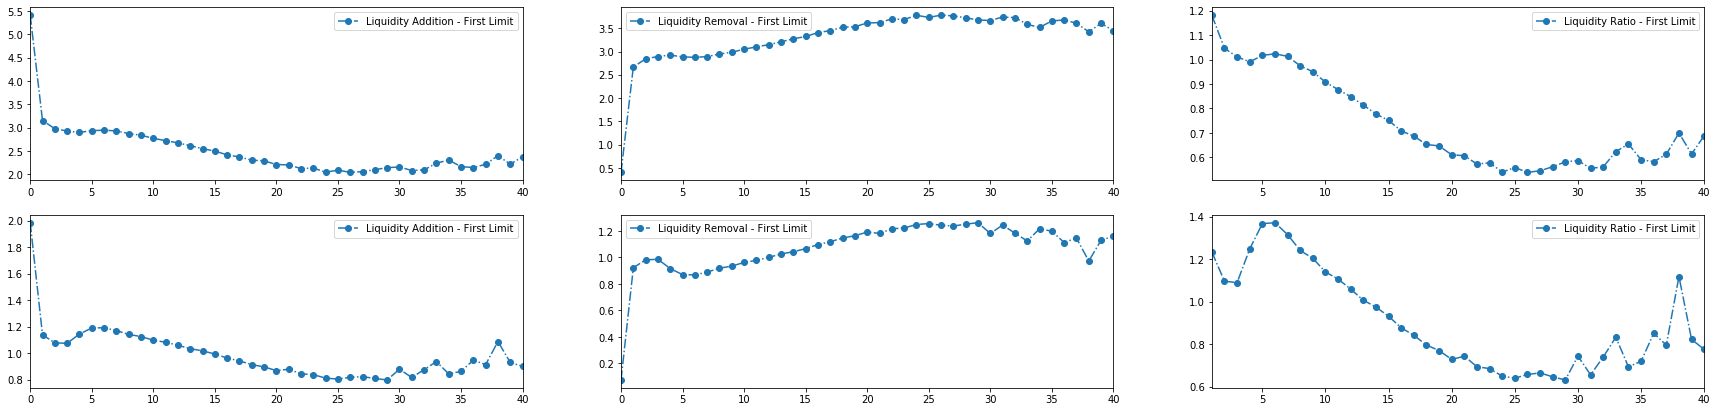

In [5]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30,7))
Lambda_plus.T.LIMIT0.plot(ax=ax1, linestyle='-.', marker='o'); ax1.legend(['Liquidity Addition - First Limit']); 
Lambda_minus.T.LIMIT0.plot(ax=ax2, linestyle='-.', marker='o'); ax2.legend(['Liquidity Removal - First Limit']); 
(Lambda_plus.T.LIMIT0 / Lambda_minus.T.LIMIT0).iloc[1:].plot(ax=ax3, linestyle='-.', marker='o'); ax3.legend(['Liquidity Ratio - First Limit']); 
Lambda_plus.T.LIMIT1.plot(ax=ax4, linestyle='-.', marker='o'); ax4.legend(['Liquidity Addition - First Limit']); 
Lambda_minus.T.LIMIT1.plot(ax=ax5, linestyle='-.', marker='o'); ax5.legend(['Liquidity Removal - First Limit']); 
(Lambda_plus.T.LIMIT1 / Lambda_minus.T.LIMIT1).iloc[1:].plot(ax=ax6, linestyle='-.', marker='o'); ax6.legend(['Liquidity Ratio - First Limit']); 

## Create the QRM Agent

In [6]:
qrm_config = {'orderbook'     : LOB,
              'id'            : 'market',
              'b_record'      : True,
              'lambdas_plus'  : 1/Lambda_plus,
              'lambdas_minus' : 1/Lambda_minus,
              'event_sizes'   : event_sizes,
              'S0'            : 4400,
              'theta'         : 0.2, # Probability that the reference price (around which the lob dynamics are constructed) changes when the mid price changes (when a first limit is depleted)
              'theta_reinit'  : 0.7, # Probability that the whole LOB dynamics to be redrawn from its invariant distribution when the ref price changes (this transition is done smoothly : no huge jump in quantities between events)
              'MOPart'        : 0.05, # % of liquidity consuming events that are market orders (5% is a historical realized value for CF1)
              'verbose'       : False}

qrm = mlob.QRM(**qrm_config)

# Launch Simulation - Basic

In [7]:
%%time 

Hours_Of_Trading = 10 # approx 7 sec of simulation per hour 

for i in range(Hours_Of_Trading * 60**2):
    qrm.sendOrders()

Wall time: 1min 6s


#### Get Simulated Mid Price Evolution

In [8]:
LOBtape = qrm.getLOBTape()

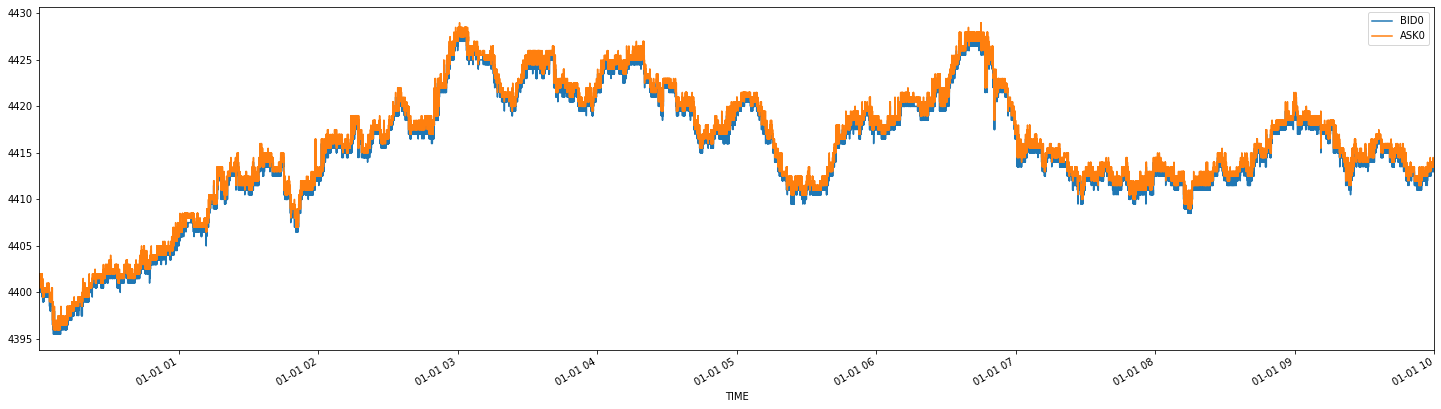

In [9]:
# the TIME columns is in number of seconds ! 
LOBtape['TIME'] = pd.to_datetime(LOBtape['TIME'], unit='s')
LOBtape = LOBtape.set_index('TIME').resample('s').last()[['BID0', 'ASK0']].dropna().astype(float)
LOBtape[['BID0', 'ASK0']].astype(float).plot(figsize=(25, 7))

In [11]:
LOBtape['MID0'] = (LOBtape.BID0 + LOBtape.ASK0) / 2
print('annualized volatility : ', 100 * (6 * 60 * 7 * 252)**0.5 * LOBtape.MID0.resample('10s').last().pct_change(1).std())

annualized volatility :  11.974465194528703


#### Get Transaction Price Tape

'open  : 4400.5'

'high  : 4416.5'

'low   : 4400.5'

'close : 4415.0'

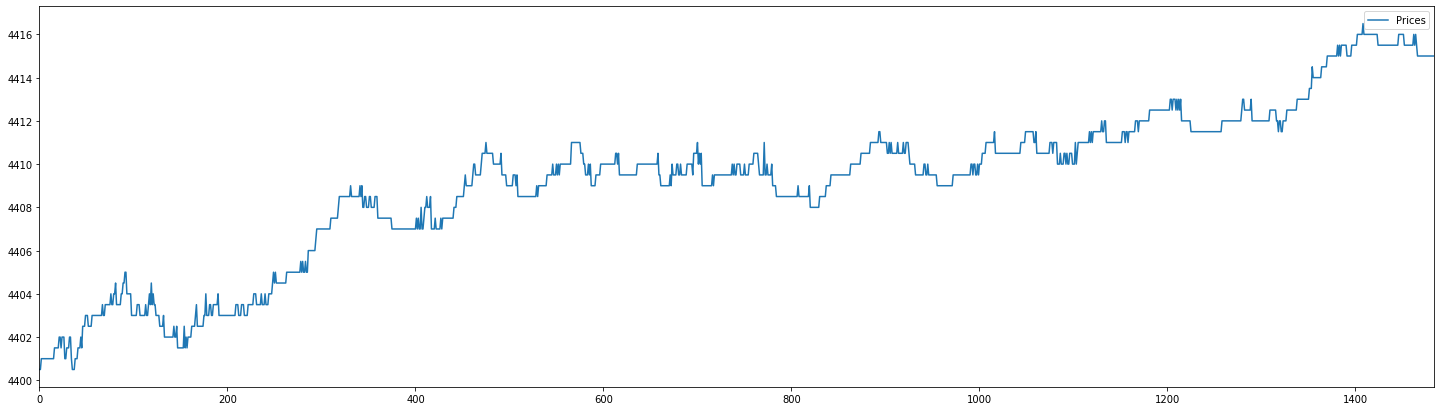

In [10]:
histoPrices = qrm.getPriceTape().astype(float)
histoPrices.plot(figsize=(25,7))

# OHLC
display(f'open  : {histoPrices.iloc[0,0]}')
display(f'high  : {histoPrices.max()[0]}')
display(f'low   : {histoPrices.min()[0]}')
display(f'close : {histoPrices.iloc[-1, 0]}')

plt.show()

# Launch simulation - with scheduler

In [11]:
#reset lob & agent
LOB.reset()
qrm = mlob.QRM(**qrm_config)

#scehduler
sched = BackgroundScheduler()

#### Here you should wait a few seconds until the full hour of trading is simulated
#### After completion, a message will appear, wait for it.
#### Alternatively, execute "sched.pause()" command or move on to other cells even if trading is still on.

In [12]:
nb_hours_of_trading=2

sched.start()
qrm.start(sched, maxruns=nb_hours_of_trading*60*60, seconds=0.0001)

In [ ]:
sched.pause()

#### Get Simulated Mid Price Evolution

In [22]:
LOBtape = qrm.getLOBTape()

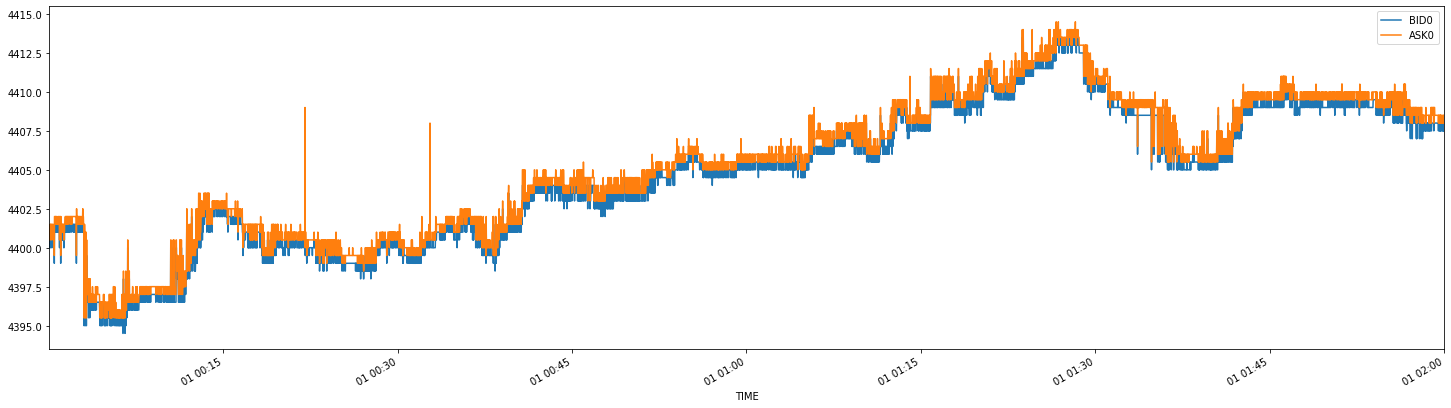

In [23]:
# the TIME columns is in number of seconds ! 
# LOBtape = LOBtape #[(LOBtape.TIME<1000000)] # clean data
LOBtape['TIME'] = pd.to_datetime(LOBtape['TIME'], unit='s')
LOBtape = LOBtape.set_index('TIME').resample('s').last()[['BID0', 'ASK0']].dropna().astype(float)
LOBtape[['BID0', 'ASK0']].astype(float).plot(figsize=(25, 7))

In [35]:
LOBtape['MID0'] = (LOBtape.BID0 + LOBtape.ASK0) / 2
print('annualized volatility : ', 100 * (6 * 60 * 7 * 252)**0.5 * LOBtape.MID0.resample('10s').last().pct_change(1).std())

annualized volatility :  13.63490396569796


#### Get Transaction Price Tape

'open  : 4410.5'

'high  : 4431.0'

'low   : 4406.0'

'close : 4431.0'

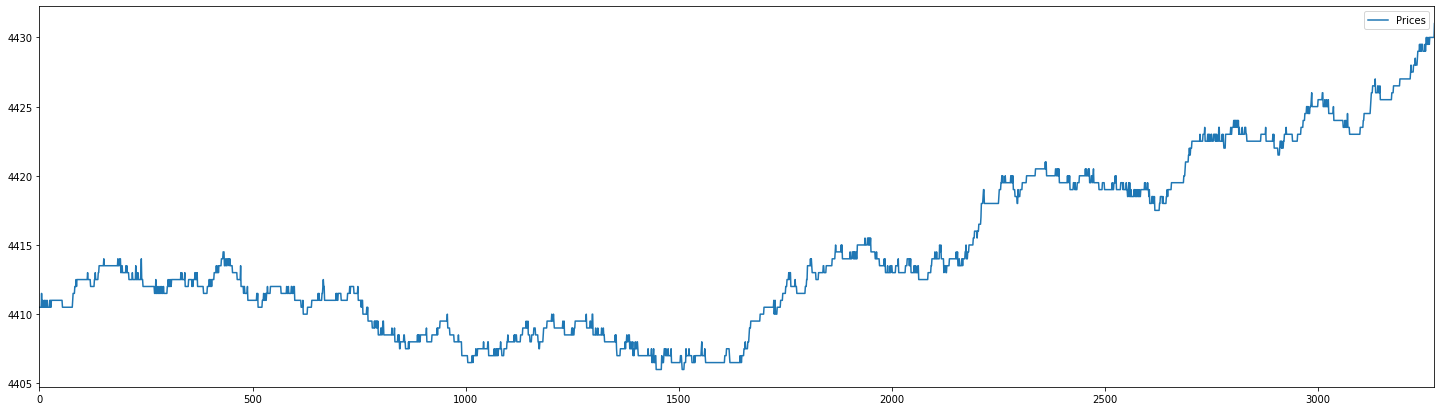

In [28]:
histoPrices = qrm.getPriceTape().astype(float)
histoPrices.plot(figsize=(25,7))

# OHLC
display(f'open  : {histoPrices.iloc[0,0]}')
display(f'high  : {histoPrices.max()[0]}')
display(f'low   : {histoPrices.min()[0]}')
display(f'close : {histoPrices.iloc[-1, 0]}')

plt.show()

## Get LOB

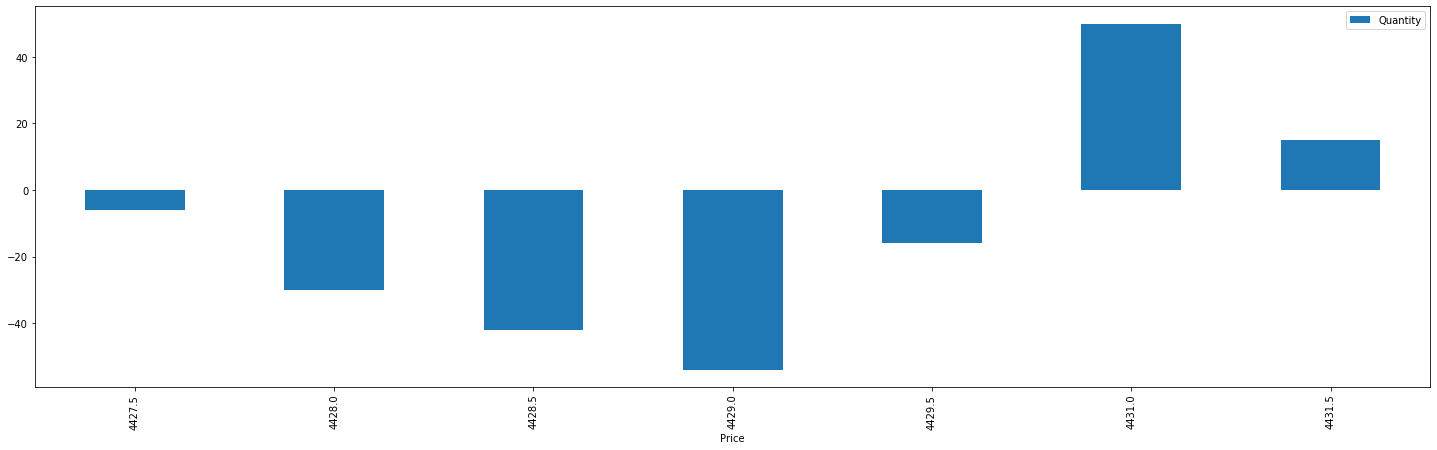

In [24]:
LOBstate = qrm.getLOBState()
LOBstate = LOBstate.set_index('Price').sort_index()
LOBstate.plot.bar(figsize=(25, 7))
plt.show()